# GP2 Tutorial - Module 5 - Example 1 - Polygenic risk score in Non-European populations

`GP2 ❤️ Open Science 😍`

- **Module:** GP2 Demo
- **Authors:** Sara Bandres-Ciga, Hampton Leonard, and Mary Makarious on behalf of the Global Parkinson's Genetics Program
- **Estimated Computation and Runtime:**
    - **Estimated Specifications:** Default; 1 CPU, 3.75 GB Memory, 50 GB Persistent Disk Size
    - **Estimated Runtime:** 30 min.
- **Date Last Updated:** 11-JULY-2022
    - **Update Description:** Finished notebook!

---
### Quick Description
These notebooks serve as a beginner's introduction to Terra, GP2, and AMP-PD data to help you get comfortable navigating the spaces, manage your costs, upload your own data, and begin running some simple analyses.


### Course Summary
- **Module 1:** Intro + demo Terra
- **Module 2:** Introduction to current AMP and GP2 data + managing costs
- **Module 3:** How to upload, access, and copy over data
- **Module 4:** How to interact with clinical data + make mini covariate files
- **Module 5:** Analysis example 1: Run PRS with PD known hits in Non-Euro pops and data viz + save results **(this notebook!)**
- **Module 6:** Analysis example 2: How to extract a gene, annotate it, run burden, and get hmz and compound hets + save results
- **Module 7:** WDL workflows: What they are + When to use + Quick example overview 

--- 
## Notebook Summary 
- Getting Started
    - Set up environment
    - Install packages
    - Copy data from GP2 Tier 2 bucket to workspace
    - GP2 Tier 2 - Data Format
- Calculating polygenic risk score
    - Extract 90 risk loci per chr from GP2-EAS populations data
    - Merge SNPs per chr in a unique file
    - Calculate scores
    - Run Logistic Regression (score versus disease status adjusted by covariates)
- Data visualization
    - Violin plot
    - Quantile plot
    - Density plot
 
## Workflow

### [Getting Started](#1)
This section goes through: 
- Set up environment
- Install packages
- Copy data from GP2 Tier 2 bucket to workspace
- GP2 Tier 2 - Data Format

### [Calculating polygenic risk score](#2)
This section goes through:
- Extract 90 risk loci per chr from GP2-EAS populations data
- Merge SNPs per chr from the GP2-EAS population data in a unique file
- Calculate scores
- Run Logistic Regression (score versus disease status adjusted by covariates)

### [Data visualization](#3)
This section goes through:
- Violin plot
- Quantile plot
- Density plot

### [Save out results](#4)
This section goes through:
- Transfer output files into the bucket


# Getting Started

## Set up environment

In [1]:
# Use the os package to interact with the environment
import os

# Bring in Pandas for Dataframe functionality
import pandas as pd

# Numpy for basics
import numpy as np

# Use StringIO for working with file contents
from io import StringIO

# Enable IPython to display matplotlib graphs
import matplotlib.pyplot as plt
%matplotlib inline

# Enable interaction with the FireCloud API
from firecloud import api as fapi

# Import the iPython HTML rendering for displaying links to Google Cloud Console
from IPython.core.display import display, HTML

# Import urllib modules for building URLs to Google Cloud Console
import urllib.parse

# BigQuery for querying data
from google.cloud import bigquery

#Import Sys
import sys as sys

In [2]:
# Set up billing project and data path variables
BILLING_PROJECT_ID = os.environ['GOOGLE_PROJECT']
WORKSPACE_NAMESPACE = os.environ['WORKSPACE_NAMESPACE']
WORKSPACE_NAME = os.environ['WORKSPACE_NAME']
WORKSPACE_BUCKET = os.environ['WORKSPACE_BUCKET']

WORKSPACE_ATTRIBUTES = fapi.get_workspace(WORKSPACE_NAMESPACE, WORKSPACE_NAME).json().get('workspace',{}).get('attributes',{})

## AMP-PD v2.5
## Explicitly define release v2.5 path 
AMP_RELEASE_PATH = 'gs://amp-pd-data/releases/2021_v2-5release_0510'
AMP_CLINICAL_RELEASE_PATH = f'{AMP_RELEASE_PATH}/clinical'

AMP_WGS_RELEASE_PATH = 'gs://amp-pd-genomics/releases/2021_v2-5release_0510/wgs'
AMP_WGS_RELEASE_PLINK_PATH = os.path.join(AMP_WGS_RELEASE_PATH, 'plink')
AMP_WGS_RELEASE_GATK_PATH = os.path.join(AMP_WGS_RELEASE_PATH, 'gatk')

## Print the information to check we are in the proper release and billing 
## This will be different for you, the user, depending on the billing project your workspace is on
print('Billing and Workspace')
print(f'Workspace Name: {WORKSPACE_NAME}')
print(f'Billing Project: {BILLING_PROJECT_ID}')
print(f'Workspace Bucket, where you can upload and download data: {WORKSPACE_BUCKET}')
print('')

print('AMP-PD v2.5')
print(f'Path to AMP-PD v2.5 Clinical Data: {AMP_CLINICAL_RELEASE_PATH}')
print(f'Path to AMP-PD v2.5 WGS Data: {AMP_WGS_RELEASE_PLINK_PATH}')
print('')

## GP2 v2.0
GP2_RELEASE_PATH = 'gs://gp2tier2/release2_06052022'
GP2_CLINICAL_RELEASE_PATH = f'{GP2_RELEASE_PATH}/clinical_data'
GP2_META_RELEASE_PATH = f'{GP2_RELEASE_PATH}/meta_data'
GP2_SUMSTAT_RELEASE_PATH = f'{GP2_RELEASE_PATH}/summary_statistics'

GP2_RAW_GENO_PATH = f'{GP2_RELEASE_PATH}/raw_genotypes'
GP2_IMPUTED_GENO_PATH = f'{GP2_RELEASE_PATH}/imputed_genotypes'
print('GP2 v2.0')
print(f'Path to GP2 v2.0 Clinical Data: {GP2_CLINICAL_RELEASE_PATH}')
print(f'Path to GP2 v2.0 Raw Genotype Data: {GP2_RAW_GENO_PATH}')
print(f'Path to GP2 v2.0 Imputed Genotype Data: {GP2_IMPUTED_GENO_PATH}')


Billing and Workspace
Workspace Name: GP2 Bioinformatics Course 2
Billing Project: terra-9b559320
Workspace Bucket, where you can upload and download data: gs://fc-c04486b2-8d7e-4359-a607-63643e9a7914

AMP-PD v2.5
Path to AMP-PD v2.5 Clinical Data: gs://amp-pd-data/releases/2021_v2-5release_0510/clinical
Path to AMP-PD v2.5 WGS Data: gs://amp-pd-genomics/releases/2021_v2-5release_0510/wgs/plink

GP2 v2.0
Path to GP2 v2.0 Clinical Data: gs://gp2tier2/release2_06052022/clinical_data
Path to GP2 v2.0 Raw Genotype Data: gs://gp2tier2/release2_06052022/raw_genotypes
Path to GP2 v2.0 Imputed Genotype Data: gs://gp2tier2/release2_06052022/imputed_genotypes


In [3]:
# Utility routine for printing a shell command before executing it
def shell_do(command):
    print(f'Executing: {command}', file=sys.stderr)
    !$command
    
def shell_return(command):
    print(f'Executing: {command}', file=sys.stderr)
    output = !$command
    return '\n'.join(output)

# Utility routine for printing a query before executing it
def bq_query(query):
    print(f'Executing: {query}', file=sys.stderr)
    return pd.read_gbq(query, project_id=BILLING_PROJECT_ID, dialect='standard')

# Utility routine for display a message and a link
def display_html_link(description, link_text, url):
    html = f'''
    <p>
    </p>
    <p>
    {description}
    <a target=_blank href="{url}">{link_text}</a>.
    </p>
    '''

    display(HTML(html))

# Utility routines for reading files from Google Cloud Storage
def gcs_read_file(path):
    """Return the contents of a file in GCS"""
    contents = !gsutil -u {BILLING_PROJECT_ID} cat {path}
    return '\n'.join(contents)
    
def gcs_read_csv(path, sep=None):
    """Return a DataFrame from the contents of a delimited file in GCS"""
    return pd.read_csv(StringIO(gcs_read_file(path)), sep=sep, engine='python')

# Utility routine for displaying a message and link to Cloud Console
def link_to_cloud_console_gcs(description, link_text, gcs_path):
    url = '{}?{}'.format(
        os.path.join('https://console.cloud.google.com/storage/browser',
                     gcs_path.replace("gs://","")),
        urllib.parse.urlencode({'userProject': BILLING_PROJECT_ID}))

    display_html_link(description, link_text, url)

## Install packages

In [4]:
%%capture
%%bash
# Install plink 1.9
cd /home/jupyter/
if test -e /home/jupyter/plink; then

echo "Plink is already installed in /home/jupyter/"
else
echo "Plink is not installed"
cd /home/jupyter

wget http://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20190304.zip 

unzip -o plink_linux_x86_64_20190304.zip
mv plink plink1.9

fi

In [5]:
%%capture
%%bash
# Install plink 2.0
cd /home/jupyter/
if test -e /home/jupyter/plink2; then

echo "Plink2 is already installed in /home/jupyter/"
else
echo "Plink2 is not installed"
cd /home/jupyter/

wget http://s3.amazonaws.com/plink2-assets/plink2_linux_x86_64_latest.zip

unzip -o plink2_linux_x86_64_latest.zip

fi

In [6]:
%%bash
# chmod plink 1.9 to make sure you have permission to run the program
chmod u+x /home/jupyter/plink1.9

In [7]:
%%bash
# chmod plink 2.0 to make sure you have permission to run the program
chmod u+x /home/jupyter/plink2

In [8]:
! pip install --upgrade rpy2
# Install R

In [9]:
%load_ext rpy2.ipython

## Copy data from GP2 Tier 2 bucket to workspace

In [10]:
# Create a folder on your workspace
print("Making a working directory")
WORK_DIR = f'/home/jupyter/PRS_test'
shell_do(f'mkdir -p {WORK_DIR}') # f' stands for f-string which contains expressions inside brackets

Making a working directory


Executing: mkdir -p /home/jupyter/PRS_test


In [11]:
# Check directory where GP2 Tier 2 data is
print("List available imputed genotype information in GP2 (broken down by ancestry)")
shell_do(f'gsutil -u {BILLING_PROJECT_ID} ls {GP2_IMPUTED_GENO_PATH}')

List available imputed genotype information in GP2 (broken down by ancestry)


Executing: gsutil -u terra-9b559320 ls gs://gp2tier2/release2_06052022/imputed_genotypes


gs://gp2tier2/release2_06052022/imputed_genotypes/AAC/
gs://gp2tier2/release2_06052022/imputed_genotypes/AFR/
gs://gp2tier2/release2_06052022/imputed_genotypes/AJ/
gs://gp2tier2/release2_06052022/imputed_genotypes/AMR/
gs://gp2tier2/release2_06052022/imputed_genotypes/CAS/
gs://gp2tier2/release2_06052022/imputed_genotypes/EAS/
gs://gp2tier2/release2_06052022/imputed_genotypes/EUR/
gs://gp2tier2/release2_06052022/imputed_genotypes/SAS/


In [12]:
! gsutil -u terra-419f6e10 ls gs://gp2tier2/release2_06052022/clinical_data/

gs://gp2tier2/release2_06052022/clinical_data/master_key_release2_final.csv
gs://gp2tier2/release2_06052022/clinical_data/release2_26042022_data_dictionary.csv


In [13]:
# Copy files from bucket to your workspace - Here we will use EAS as an example
shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp -r {GP2_IMPUTED_GENO_PATH}/EAS {WORK_DIR}')
shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp {GP2_META_RELEASE_PATH}/projected_pcs.csv {WORK_DIR}')
shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp {GP2_CLINICAL_RELEASE_PATH}/master_key_release2_final.csv {WORK_DIR}')

Executing: gsutil -u terra-9b559320 -m cp -r gs://gp2tier2/release2_06052022/imputed_genotypes/EAS /home/jupyter/PRS_test


Copying gs://gp2tier2/release2_06052022/imputed_genotypes/EAS/chr10_EAS_release2.psam...
Copying gs://gp2tier2/release2_06052022/imputed_genotypes/EAS/chr11_EAS_release2.log...
Copying gs://gp2tier2/release2_06052022/imputed_genotypes/EAS/chr10_EAS_release2.pgen...
Copying gs://gp2tier2/release2_06052022/imputed_genotypes/EAS/chr10_EAS_release2.log...
Copying gs://gp2tier2/release2_06052022/imputed_genotypes/EAS/chr10_EAS_release2.pvar...
Copying gs://gp2tier2/release2_06052022/imputed_genotypes/EAS/chr13_EAS_release2.pgen...
Copying gs://gp2tier2/release2_06052022/imputed_genotypes/EAS/chr11_EAS_release2.pgen...
Copying gs://gp2tier2/release2_06052022/imputed_genotypes/EAS/chr11_EAS_release2.pvar...
Copying gs://gp2tier2/release2_06052022/imputed_genotypes/EAS/chr12_EAS_release2.psam...
Copying gs://gp2tier2/release2_06052022/imputed_genotypes/EAS/chr13_EAS_release2.pvar...
Copying gs://gp2tier2/release2_06052022/imputed_genotypes/EAS/chr12_EAS_release2.log...
Copying gs://gp2tier2/re

Executing: gsutil -u terra-9b559320 -m cp gs://gp2tier2/release2_06052022/meta_data/projected_pcs.csv /home/jupyter/PRS_test


Copying gs://gp2tier2/release2_06052022/meta_data/projected_pcs.csv...
- [1/1 files][ 11.0 MiB/ 11.0 MiB] 100% Done                                    
Operation completed over 1 objects/11.0 MiB.                                     


Executing: gsutil -u terra-9b559320 -m cp gs://gp2tier2/release2_06052022/clinical_data/master_key_release2_final.csv /home/jupyter/PRS_test


Copying gs://gp2tier2/release2_06052022/clinical_data/master_key_release2_final.csv...
/ [1/1 files][725.5 KiB/725.5 KiB] 100% Done                                    
Operation completed over 1 objects/725.5 KiB.                                    


In [14]:
# Import manually files that you would like to copy in Terra and then transfer them into your notebook workspace
shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp gs://fc-secure-e7ee53f9-e643-4d4b-b4b8-955c8ad7b23e/CHR_POS_HG38.txt {WORK_DIR}')
shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp gs://fc-secure-e7ee53f9-e643-4d4b-b4b8-955c8ad7b23e/PD_risk_hg38.txt {WORK_DIR}')
shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp gs://fc-927e9f1a-8edc-420f-99b1-302bb53caacf/Release2_unrelated_individuals_PIHAT0125.txt {WORK_DIR}')


Executing: gsutil -u terra-9b559320 -m cp gs://fc-secure-e7ee53f9-e643-4d4b-b4b8-955c8ad7b23e/CHR_POS_HG38.txt /home/jupyter/PRS_test


BucketNotFoundException: 404 gs://fc-secure-e7ee53f9-e643-4d4b-b4b8-955c8ad7b23e bucket does not exist.
CommandException: 1 file/object could not be transferred.


Executing: gsutil -u terra-9b559320 -m cp gs://fc-secure-e7ee53f9-e643-4d4b-b4b8-955c8ad7b23e/PD_risk_hg38.txt /home/jupyter/PRS_test


BucketNotFoundException: 404 gs://fc-secure-e7ee53f9-e643-4d4b-b4b8-955c8ad7b23e bucket does not exist.
CommandException: 1 file/object could not be transferred.


Executing: gsutil -u terra-9b559320 -m cp gs://fc-927e9f1a-8edc-420f-99b1-302bb53caacf/Release2_unrelated_individuals_PIHAT0125.txt /home/jupyter/PRS_test


Copying gs://fc-927e9f1a-8edc-420f-99b1-302bb53caacf/Release2_unrelated_individuals_PIHAT0125.txt...
/ [1/1 files][165.2 KiB/165.2 KiB] 100% Done                                    
Operation completed over 1 objects/165.2 KiB.                                    


## GP2 Tier 2 - Data Format

In [15]:
%%bash

WORK_DIR=/home/jupyter/PRS_test
cd $WORK_DIR

# GP2 Tier 2 imputed genotypes
# Plink2 format: psam file contains IID, SEX, PHENO columns
# head chr1_EAS_release2.psam

# *psam is the equivalent of *fam format in Plink1.9

In [16]:
%%bash

WORK_DIR=/home/jupyter/PRS_test
cd $WORK_DIR

# GP2 Tier 2 imputed genotypes
# Plink2 format: pvar file contains CHR, POS, variant ID, A1, A2, QUALITY, INFO
tail $WORK_DIR/EAS/chr1_EAS_release2.pvar

# *pvar is the equivalent of *bim format in Plink1.9

1	248939578	chr1:248939578:A:G	A	G	PASS	AF=0.01360;MAF=0.01360;R2=0.43469;IMPUTED
1	248939581	chr1:248939581:A:C	A	C	PASS	AF=0.01494;MAF=0.01494;R2=0.66674;IMPUTED
1	248939697	chr1:248939697:C:T	C	T	PASS	AF=0.01511;MAF=0.01511;R2=0.45473;IMPUTED
1	248939732	chr1:248939732:TGA:T	TGA	T	PASS	AF=0.02359;MAF=0.02359;R2=0.58059;IMPUTED
1	248939739	chr1:248939739:C:A	C	A	PASS	AF=0.01894;MAF=0.01894;R2=0.42613;IMPUTED
1	248941149	chr1:248941149:T:C	T	C	PASS	AF=0.01763;MAF=0.01763;R2=0.35114;IMPUTED
1	248941186	chr1:248941186:GGA:G	GGA	G	PASS	AF=0.01649;MAF=0.01649;R2=0.49812;IMPUTED
1	248941191	chr1:248941191:T:C	T	C	PASS	AF=0.01472;MAF=0.01472;R2=0.44150;IMPUTED
1	248941436	chr1:248941436:CT:C	CT	C	PASS	AF=0.01132;MAF=0.01132;R2=0.46251;IMPUTED
1	248941609	chr1:248941609:T:C	T	C	PASS	AF=0.00618;MAF=0.00618;R2=0.39686;IMPUTED


In [17]:
%%bash

WORK_DIR=/home/jupyter/PRS_test
cd $WORK_DIR

# GP2 Tier 2 imputed genotypes
# Plink2 format: 
tail $WORK_DIR/EAS/chr13_EAS_release2.pgen

# *pgen is the equivalent of *bed format in Plink1.9

?b ��V>� ;?!  R �0q=�� � B � ! ! �� 1 }?� � )�����������z����?�͚�R �R b s ����-�� ��X��� ��o1 ���N�1 7��  ?��HB �+��� +���P \�mǜ�� �u���  ����1 7� ����3;h1 N! �'J�
��`��� b���  � ��1 ! R R ��h��b�1�!  s F��� ��B ���s ���òž������! ������!  ��
		
$ ��y��A�  BvhA@A  ! s  s 
??=X+?>? �>�<B ! �> B 
?�/ �>1 > �>   ? !   �=�     =?�m��  ! �������� B ����B R� 1 �� �� o� !  ���     = $ ��y��A�$ BvhQ@A   ! s  s 
?=X+?>? �>�<B ! �> B 
?�/ �>1  �> �>   ? !   `= �     ="��   ! �������� B ����B R� 1  �� �� o� !  �� �     =6	 !  �6 ! s  ! ��H�����s w^���w��{�k��;�� ��  �+7�S{�9LX�#u;�ABH�4�X�?=�3�; (d�j)Lf� 1X)}'�;WF�<3C�>yY�?\�4�<m�!�C�)RZ,�g{<%^'1�4�C�"�+�W-`*�KuK�AB`�J�%Z}/Z$h	3kP=�#9f6Y�C5�@5V�!�i�E�:\?�C�P%V?E#+� L7�P##�D�S5>�6q]9D:�D�P�H� �@�DDS�-55LhY�F�3Hi�6��95�$�\�=�;o2�Pf%^AD;=-B*VFw.�G�1

In [18]:
# GP2 Tier 2 covariate file (master_key_release1)
WORK_DIR = '/home/jupyter/PRS_test/'
FULL_PATH = WORK_DIR + 'master_key_release2_final.csv'
cov = pd.read_csv(FULL_PATH)
cov.columns

Index(['GP2ID', 'GP2sampleID', 'manifest_id', 'Phenotype', 'sex_for_qc', 'age',
       'age_of_onset', 'age_at_diagnosis', 'age_at_death', 'race_for_qc',
       'family_history_for_qc', 'region_for_qc', 'study'],
      dtype='object')

In [19]:
# GP2 Tier 2 covariate file (projected PCs)
WORK_DIR = '/home/jupyter/PRS_test/'
FULL_PATH = WORK_DIR + 'projected_pcs.csv'
cov = pd.read_csv(FULL_PATH)
cov.columns

Index(['FID', 'IID', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8',
       'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17',
       'PC18', 'PC19', 'PC20', 'PC21', 'PC22', 'PC23', 'PC24', 'PC25', 'PC26',
       'PC27', 'PC28', 'PC29', 'PC30', 'PC31', 'PC32', 'PC33', 'PC34', 'PC35',
       'PC36', 'PC37', 'PC38', 'PC39', 'PC40', 'PC41', 'PC42', 'PC43', 'PC44',
       'PC45', 'PC46', 'PC47', 'PC48', 'PC49', 'PC50', 'label'],
      dtype='object')

# Calculating polygenic risk score

## Extract 90 risk loci per chr from GP2-EAS populations data

In [20]:
%%bash -s "$WORK_DIR"
cd $1

for chnum in {1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22};
do
    /home/jupyter/plink2 \
    --pfile EAS/chr"$chnum"_EAS_release2 \
    --extract range CHR_POS_HG38.txt \
    --make-bed \
    --out EAS/PRS_chr"$chnum"_EAS_release2
done

PLINK v2.00a3.3LM 64-bit Intel (3 Jun 2022)    www.cog-genomics.org/plink/2.0/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to EAS/PRS_chr1_EAS_release2.log.
Options in effect:
  --extract range CHR_POS_HG38.txt
  --make-bed
  --out EAS/PRS_chr1_EAS_release2
  --pfile EAS/chr1_EAS_release2

Start time: Fri Sep  2 15:12:30 2022
15000 MiB RAM detected; reserving 7500 MiB for main workspace.
Using up to 4 compute threads.
149 samples (77 females, 72 males; 149 founders) loaded from
EAS/chr1_EAS_release2.psam.
770904 variants loaded from EAS/chr1_EAS_release2.pvar.
1 binary phenotype loaded (70 cases, 79 controls).
--extract bed1: 770898 variants excluded.
6 variants remaining after main filters.
Writing EAS/PRS_chr1_EAS_release2.fam ... done.
Writing EAS/PRS_chr1_EAS_release2.bim ... done.
Writing EAS/PRS_chr1_EAS_release2.bed ... 0%16%33%66%done.
End time: Fri Sep  2 15:12:30 2022
PLINK v2.00a3.3LM 64-bit Intel (3 Jun 2022)    www.cog-

Error: No variants remaining after main filters.


CalledProcessError: Command 'b'cd $1\n\nfor chnum in {1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22};\ndo\n    /home/jupyter/plink2 \\\n    --pfile EAS/chr"$chnum"_EAS_release2 \\\n    --extract range CHR_POS_HG38.txt \\\n    --make-bed \\\n    --out EAS/PRS_chr"$chnum"_EAS_release2\ndone\n'' returned non-zero exit status 13.

In [21]:
%%bash -s "$WORK_DIR/EAS"
cd $1

# List files
ls

chr10_EAS_release2.log
chr10_EAS_release2.pgen
chr10_EAS_release2.psam
chr10_EAS_release2.pvar
chr11_EAS_release2.log
chr11_EAS_release2.pgen
chr11_EAS_release2.psam
chr11_EAS_release2.pvar
chr12_EAS_release2.log
chr12_EAS_release2.pgen
chr12_EAS_release2.psam
chr12_EAS_release2.pvar
chr13_EAS_release2.log
chr13_EAS_release2.pgen
chr13_EAS_release2.psam
chr13_EAS_release2.pvar
chr14_EAS_release2.log
chr14_EAS_release2.pgen
chr14_EAS_release2.psam
chr14_EAS_release2.pvar
chr15_EAS_release2.log
chr15_EAS_release2.pgen
chr15_EAS_release2.psam
chr15_EAS_release2.pvar
chr16_EAS_release2.log
chr16_EAS_release2.pgen
chr16_EAS_release2.psam
chr16_EAS_release2.pvar
chr17_EAS_release2.log
chr17_EAS_release2.pgen
chr17_EAS_release2.psam
chr17_EAS_release2.pvar
chr18_EAS_release2.log
chr18_EAS_release2.pgen
chr18_EAS_release2.psam
chr18_EAS_release2.pvar
chr19_EAS_release2.log
chr19_EAS_release2.pgen
chr19_EAS_release2.psam
chr19_EAS_release2.pvar
chr1_EAS_release2.log
chr1_EAS_release2.pgen
chr1_

In [22]:
! ls /home/jupyter/PRS_test/EAS/ # list files # list files

chr10_EAS_release2.log	 plotQuantile_EAS.png
chr10_EAS_release2.pgen  PRS_ALL_EAS_release.bed
chr10_EAS_release2.psam  PRS_ALL_EAS_release.bim
chr10_EAS_release2.pvar  PRS_ALL_EAS_release.fam
chr11_EAS_release2.log	 PRS_ALL_EAS_release.log
chr11_EAS_release2.pgen  PRS_chr10_EAS_release2.bed
chr11_EAS_release2.psam  PRS_chr10_EAS_release2.bim
chr11_EAS_release2.pvar  PRS_chr10_EAS_release2.fam
chr12_EAS_release2.log	 PRS_chr10_EAS_release2.log
chr12_EAS_release2.pgen  PRS_chr11_EAS_release2.bed
chr12_EAS_release2.psam  PRS_chr11_EAS_release2.bim
chr12_EAS_release2.pvar  PRS_chr11_EAS_release2.fam
chr13_EAS_release2.log	 PRS_chr11_EAS_release2.log
chr13_EAS_release2.pgen  PRS_chr12_EAS_release2.bed
chr13_EAS_release2.psam  PRS_chr12_EAS_release2.bim
chr13_EAS_release2.pvar  PRS_chr12_EAS_release2.fam
chr14_EAS_release2.log	 PRS_chr12_EAS_release2.log
chr14_EAS_release2.pgen  PRS_chr13_EAS_release2.bed
chr14_EAS_release2.psam  PRS_chr13_EAS_release2.bim
chr14_EAS_release2.pvar  PRS_chr13_

In [23]:
%%bash -s "$WORK_DIR/EAS"
cd $1

# Take a look at a log file
cat PRS_chr7_EAS_release2.log

PLINK v2.00a3.3LM 64-bit Intel (3 Jun 2022)
Options in effect:
  --extract range CHR_POS_HG38.txt
  --make-bed
  --out EAS/PRS_chr7_EAS_release2
  --pfile EAS/chr7_EAS_release2

Hostname: 3e1e666b3897
Working directory: /home/jupyter/PRS_test
Start time: Fri Sep  2 15:12:30 2022

Random number seed: 1662131550
15000 MiB RAM detected; reserving 7500 MiB for main workspace.
Using up to 4 compute threads.
149 samples (77 females, 72 males; 149 founders) loaded from
EAS/chr7_EAS_release2.psam.
578966 variants loaded from EAS/chr7_EAS_release2.pvar.
1 binary phenotype loaded (70 cases, 79 controls).
--extract bed1: 578964 variants excluded.
2 variants remaining after main filters.
Writing EAS/PRS_chr7_EAS_release2.fam ... done.
Writing EAS/PRS_chr7_EAS_release2.bim ... done.
Writing EAS/PRS_chr7_EAS_release2.bed ... done.

End time: Fri Sep  2 15:12:31 2022


In [24]:
# Take a look at a log file
! cat /home/jupyter/PRS_test/EAS/PRS_chr7_EAS_release2.log

PLINK v2.00a3.3LM 64-bit Intel (3 Jun 2022)
Options in effect:
  --extract range CHR_POS_HG38.txt
  --make-bed
  --out EAS/PRS_chr7_EAS_release2
  --pfile EAS/chr7_EAS_release2

Hostname: 3e1e666b3897
Working directory: /home/jupyter/PRS_test
Start time: Fri Sep  2 15:12:30 2022

Random number seed: 1662131550
15000 MiB RAM detected; reserving 7500 MiB for main workspace.
Using up to 4 compute threads.
149 samples (77 females, 72 males; 149 founders) loaded from
EAS/chr7_EAS_release2.psam.
578966 variants loaded from EAS/chr7_EAS_release2.pvar.
1 binary phenotype loaded (70 cases, 79 controls).
--extract bed1: 578964 variants excluded.
2 variants remaining after main filters.
Writing EAS/PRS_chr7_EAS_release2.fam ... done.
Writing EAS/PRS_chr7_EAS_release2.bim ... done.
Writing EAS/PRS_chr7_EAS_release2.bed ... done.

End time: Fri Sep  2 15:12:31 2022


In [36]:
%%bash -s "$WORK_DIR/EAS"
cd $1

# Make a list that includes the files per chr that you just generated
ls *bim > temp
head temp

PRS_chr10_EAS_release2.bim
PRS_chr11_EAS_release2.bim
PRS_chr12_EAS_release2.bim
PRS_chr13_EAS_release2.bim
PRS_chr14_EAS_release2.bim
PRS_chr15_EAS_release2.bim
PRS_chr16_EAS_release2.bim
PRS_chr17_EAS_release2.bim
PRS_chr18_EAS_release2.bim
PRS_chr19_EAS_release2.bim


In [37]:
%%bash -s "$WORK_DIR/EAS"
cd $1

# Remove *bim so you only keep the core name
sed 's/.bim//g' temp > temp2
cat temp2

PRS_chr10_EAS_release2
PRS_chr11_EAS_release2
PRS_chr12_EAS_release2
PRS_chr13_EAS_release2
PRS_chr14_EAS_release2
PRS_chr15_EAS_release2
PRS_chr16_EAS_release2
PRS_chr17_EAS_release2
PRS_chr18_EAS_release2
PRS_chr19_EAS_release2
PRS_chr1_EAS_release2
PRS_chr20_EAS_release2
PRS_chr21_EAS_release2
PRS_chr2_EAS_release2
PRS_chr3_EAS_release2
PRS_chr4_EAS_release2
PRS_chr5_EAS_release2
PRS_chr6_EAS_release2
PRS_chr7_EAS_release2
PRS_chr8_EAS_release2
PRS_chr9_EAS_release2


In [38]:
%%bash -s "$WORK_DIR/EAS"
cd $1

# Remove chr1 from the list so we do not merge it twice
grep -v "PRS_chr1_EAS_release2" temp2 > files.txt
cat files.txt

PRS_chr10_EAS_release2
PRS_chr11_EAS_release2
PRS_chr12_EAS_release2
PRS_chr13_EAS_release2
PRS_chr14_EAS_release2
PRS_chr15_EAS_release2
PRS_chr16_EAS_release2
PRS_chr17_EAS_release2
PRS_chr18_EAS_release2
PRS_chr19_EAS_release2
PRS_chr20_EAS_release2
PRS_chr21_EAS_release2
PRS_chr2_EAS_release2
PRS_chr3_EAS_release2
PRS_chr4_EAS_release2
PRS_chr5_EAS_release2
PRS_chr6_EAS_release2
PRS_chr7_EAS_release2
PRS_chr8_EAS_release2
PRS_chr9_EAS_release2


## Merge SNPs per chr in a unique file

In [39]:
%%bash -s "$WORK_DIR/EAS"
cd $1

# Merge list using chr 1 as your core input
/home/jupyter/plink1.9 \
--bfile PRS_chr1_EAS_release2 \
--merge-list files.txt \
--make-bed \
--out PRS_ALL_EAS_release

PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to PRS_ALL_EAS_release.log.
Options in effect:
  --bfile PRS_chr1_EAS_release2
  --make-bed
  --merge-list files.txt
  --out PRS_ALL_EAS_release

15000 MB RAM detected; reserving 7500 MB for main workspace.
Performing single-pass merge (149 people, 83 variants).
Merged fileset written to PRS_ALL_EAS_release-merge.bed +
PRS_ALL_EAS_release-merge.bim + PRS_ALL_EAS_release-merge.fam .
83 variants loaded from .bim file.
149 people (72 males, 77 females) loaded from .fam.
149 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 149 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%

In [40]:
%%bash -s "$WORK_DIR/EAS"
cd $1

# Check number of lines on the merged file
wc -l PRS_ALL_EAS_release.bim

83 PRS_ALL_EAS_release.bim


In [41]:
%%bash -s "$WORK_DIR/EAS"
cd $1

# Head it
head PRS_ALL_EAS_release.bim

1	chr1:161499264:G:C	0	161499264	C	G
1	chr1:171750629:C:T	0	171750629	T	C
1	chr1:205754444:C:T	0	205754444	C	T
1	chr1:205768611:G:A	0	205768611	A	G
1	chr1:226728377:T:C	0	226728377	C	T
1	chr1:232528865:C:T	0	232528865	T	C
2	chr2:17966582:A:T	0	17966582	T	A
2	chr2:95335195:A:T	0	95335195	A	T
2	chr2:101780501:T:A	0	101780501	A	T
2	chr2:134707046:A:G	0	134707046	A	G


In [42]:
%%bash -s "$WORK_DIR/EAS"
cd $1

# Reformat *bim file (concatenate first and fourth columns and replace second)
awk '{print $1, $1":"$4, $3, $4, $5, $6}' PRS_ALL_EAS_release.bim > temp2
head temp2

1 1:161499264 0 161499264 C G
1 1:171750629 0 171750629 T C
1 1:205754444 0 205754444 C T
1 1:205768611 0 205768611 A G
1 1:226728377 0 226728377 C T
1 1:232528865 0 232528865 T C
2 2:17966582 0 17966582 T A
2 2:95335195 0 95335195 A T
2 2:101780501 0 101780501 A T
2 2:134707046 0 134707046 A G


In [43]:
%%bash -s "$WORK_DIR/EAS"
cd $1

# Replace temp2 by new bim file
mv temp2 PRS_ALL_EAS_release.bim

## Calculate scores

In [44]:
%%bash -s "$WORK_DIR"
cd $1

/home/jupyter/plink1.9 \
--bfile EAS/PRS_ALL_EAS_release \
--keep Release2_unrelated_individuals_PIHAT0125.txt \
--score PD_risk_hg38.txt \
--out EAS/PRS_score_EAS_release

PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to EAS/PRS_score_EAS_release.log.
Options in effect:
  --bfile EAS/PRS_ALL_EAS_release
  --keep Release2_unrelated_individuals_PIHAT0125.txt
  --out EAS/PRS_score_EAS_release
  --score PD_risk_hg38.txt

15000 MB RAM detected; reserving 7500 MB for main workspace.
83 variants loaded from .bim file.
149 people (72 males, 77 females) loaded from .fam.
149 phenotype values loaded from .fam.
--keep: 149 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 149 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%

to allele code mismatch); see EAS/PRS_score_EAS_release.nopred for details.


In [45]:
%%bash -s "$WORK_DIR/EAS"
cd $1

# Head file
# head PRS_score_EAS_release.profile

## Run Logistic Regression (score versus disease status adjusted by covariates)

In [46]:
# GP2 Tier 2 covariate file (master_key_release1)
WORK_DIR = '/home/jupyter/PRS_test/'
FULL_PATH = WORK_DIR + '/master_key_release2_final.csv'
cov = pd.read_csv(FULL_PATH)
cov.columns
# cov.head()

Index(['GP2ID', 'GP2sampleID', 'manifest_id', 'Phenotype', 'sex_for_qc', 'age',
       'age_of_onset', 'age_at_diagnosis', 'age_at_death', 'race_for_qc',
       'family_history_for_qc', 'region_for_qc', 'study'],
      dtype='object')

In [47]:
cov_reduced = cov[['GP2sampleID', 'sex_for_qc', 'age']]
cov_reduced.rename(columns = {'GP2sampleID':'IID'}, inplace = True)
# cov_reduced.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [48]:
# GP2 Tier 2 covariate file (projected PCs)
WORK_DIR = '/home/jupyter/PRS_test/'
FULL_PATH = WORK_DIR + 'projected_pcs.csv'
cov2 = pd.read_csv(FULL_PATH)
cov2.columns

Index(['FID', 'IID', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8',
       'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17',
       'PC18', 'PC19', 'PC20', 'PC21', 'PC22', 'PC23', 'PC24', 'PC25', 'PC26',
       'PC27', 'PC28', 'PC29', 'PC30', 'PC31', 'PC32', 'PC33', 'PC34', 'PC35',
       'PC36', 'PC37', 'PC38', 'PC39', 'PC40', 'PC41', 'PC42', 'PC43', 'PC44',
       'PC45', 'PC46', 'PC47', 'PC48', 'PC49', 'PC50', 'label'],
      dtype='object')

In [49]:
# Merge datasets by IID
WORK_DIR = '/home/jupyter/PRS_test/'
FULL_PATH = WORK_DIR + 'projected_pcs.csv'
cov2 = pd.read_csv(FULL_PATH)
cov2.head()
cov_final = cov2.merge(cov_reduced, on='IID') # Horizontal.
cov_final.to_csv('/home/jupyter/PRS_test/EAS/gp2_covs.csv', header=True, index=False)

In [50]:
! ls /home/jupyter/PRS_test/EAS/gp2_covs.csv

/home/jupyter/PRS_test/EAS/gp2_covs.csv


In [51]:
%%R
pack <- "/home/jupyter/"
temp_data <- read.table("/home/jupyter/PRS_test/EAS/PRS_score_EAS_release.profile", header = T) 
temp_covs <- read.table("/home/jupyter/PRS_test/EAS/gp2_covs.csv", header = T, sep=",")
data <- merge(temp_data, temp_covs, by = "IID")
data$CASE <- data$PHENO - 1
data$sex_for_qc[data$sex_for_qc =="Male"] <- 1
data$sex_for_qc[data$sex_for_qc =="Female"] <- 2
data$sex_for_qc <- as.numeric(data$sex_for_qc)
meanControls <- mean(data$SCORE[data$CASE == 0])
sdControls <- sd(data$SCORE[data$CASE == 0])
data$zSCORE <- (data$SCORE - meanControls)/sdControls
grsTests <- glm(CASE ~ zSCORE +  sex_for_qc + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + age, family="binomial", data = data)
summary(grsTests)


Call:
glm(formula = CASE ~ zSCORE + sex_for_qc + PC1 + PC2 + PC3 + 
    PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + age, family = "binomial", 
    data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1500  -0.8280  -0.4845   0.9428   2.0983  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)  
(Intercept) -4.17769    2.48069  -1.684   0.0922 .
zSCORE       0.35247    0.23378   1.508   0.1316  
sex_for_qc  -0.64523    0.42321  -1.525   0.1274  
PC1         -0.14013    0.15866  -0.883   0.3771  
PC2          0.01326    0.06034   0.220   0.8260  
PC3         -0.05162    0.13948  -0.370   0.7113  
PC4         -0.27544    0.14301  -1.926   0.0541 .
PC5         -0.09022    0.15465  -0.583   0.5596  
PC6          0.12954    0.06247   2.074   0.0381 *
PC7         -0.03143    0.15994  -0.197   0.8442  
PC8         -0.23061    0.17658  -1.306   0.1916  
PC9          0.18704    0.16644   1.124   0.2611  
PC10         0.08133    0.13153   0.618   0.5364

In [52]:
%%R
pack <- "/home/jupyter/"
OR <- exp(0.36270) #exp(beta)
print(OR)
U95 <- 1.96*0.36270 + 0.02358 #1.96 * beta + SE
print(U95)
L95 <- 1.96*0.36270 - 0.02358 #1.96 * beta - SE
print(L95)

[1] 1.437205
[1] 0.734472
[1] 0.687312


# Data visualization

R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/ggplot2_3.3.6.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 3061989 bytes (2.9 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to con

[1] 0.0003987903
[1] 0.003239469
     IID                FID.x       PHENO           CNT           CNT2     
 Length:149         Min.   :0   Min.   :1.00   Min.   :144   Min.   :52.0  
 Class :character   1st Qu.:0   1st Qu.:1.00   1st Qu.:154   1st Qu.:65.0  
 Mode  :character   Median :0   Median :1.00   Median :156   Median :68.0  
                    Mean   :0   Mean   :1.47   Mean   :156   Mean   :68.3  
                    3rd Qu.:0   3rd Qu.:2.00   3rd Qu.:158   3rd Qu.:72.0  
                    Max.   :0   Max.   :2.00   Max.   :166   Max.   :83.0  
                                                                           
     SCORE                FID.y        PC1               PC2        
 Min.   :-0.0071243   Min.   :0   Min.   :-19.293   Min.   : 7.902  
 1st Qu.:-0.0006002   1st Qu.:0   1st Qu.:-15.359   1st Qu.: 9.807  
 Median : 0.0008342   Median :0   Median :-13.499   Median :11.703  
 Mean   : 0.0009234   Mean   :0   Mean   :-13.885   Mean   :16.642  
 3rd Qu.: 0.00

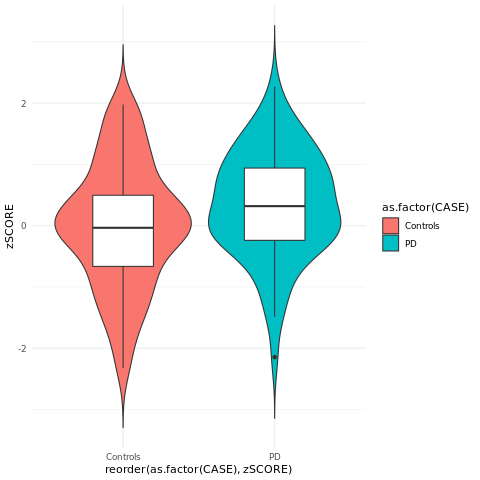

In [53]:
%%R
#Violin plot
install.packages("ggplot2", lib = pack)
library("ggplot2")
pack <- "/home/jupyter/"
temp_data <- read.table("/home/jupyter/PRS_test/EAS/PRS_score_EAS_release.profile", header = T) 
temp_covs <- read.table("/home/jupyter/PRS_test/EAS/gp2_covs.csv", header = T, sep=",")
data <- merge(temp_data, temp_covs, by = "IID")
data$CASE <- data$PHENO - 1
meanControls <- mean(data$SCORE[data$CASE == 0])
sdControls <- sd(data$SCORE[data$CASE == 0])
data$zSCORE <- (data$SCORE - meanControls)/sdControls
data$CASE[data$CASE ==0] <- "Controls"
data$CASE[data$CASE ==1] <- "PD"
print(meanControls)
print(sdControls)
print(summary(data))

p <- ggplot(data, aes(x= reorder(as.factor(CASE), zSCORE), y=zSCORE, fill=as.factor(CASE))) +
  geom_violin(trim=FALSE)
p2 <- p+geom_boxplot(width=0.4, fill="white" ) + theme_minimal()
p2 + scale_fill_manual(values=c("lightblue", "orange")) + theme_bw() + ylab("PD GRS (Z-transformed)") +xlab("") + theme(legend.position = "none")
ggsave("/home/jupyter/PRS_test/EAS/PD_GRS_EAS.jpeg", dpi = 600, units = "in", height = 6, width = 6)
p2


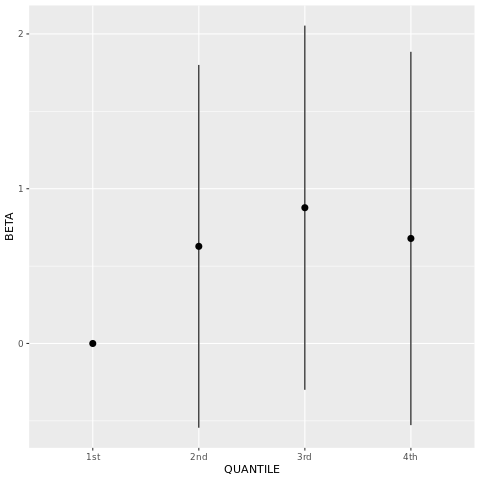

In [54]:
%%R
# Quantile plot
library("ggplot2")
pack <- "/home/jupyter/"
temp_data <- read.table("/home/jupyter/PRS_test/EAS/PRS_score_EAS_release.profile", header = T) 
temp_covs <- read.table("/home/jupyter/PRS_test/EAS/gp2_covs.csv", header = T, sep=",")
data <- merge(temp_data, temp_covs, by = "IID")
data$CASE <- data$PHENO - 1
meanControls <- mean(data$SCORE[data$CASE == 0])
sdControls <- sd(data$SCORE[data$CASE == 0])
head(data)
data$zSCORE <- (data$SCORE - meanControls)/sdControls

# Quantile plot: Create quantiles
data$quantile1 <- ifelse(data$zSCORE <= quantile(data$zSCORE)[2], 1, 0)
data$quantile2 <- ifelse(data$zSCORE > quantile(data$zSCORE)[2] & data$zSCORE <= quantile(data$zSCORE)[3], 1, 0)
data$quantile3 <- ifelse(data$zSCORE > quantile(data$zSCORE)[3] & data$zSCORE <= quantile(data$zSCORE)[4], 1, 0)
data$quantile4 <- ifelse(data$zSCORE > quantile(data$zSCORE)[4], 1, 0)
data$quantiles <- 1
data$quantiles[data$quantile2 == 1] <- 2
data$quantiles[data$quantile3 == 1] <- 3
data$quantiles[data$quantile4 == 1] <- 4
quintileTests <- glm(CASE ~ as.factor(data$quantiles) + age + sex_for_qc + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10, family="binomial", data = data)

# Quantile plot: Summarize regression and make a table
summary(quintileTests)
summary_stats <- data.frame(summary(quintileTests)$coef[2:4,1:2])
names(summary_stats) <- c("BETA","SE")
summary_stats$QUANTILE <- c("2nd","3rd","4th")
summary_stats[4,] <- c(0,0,"1st")
summary_stats_sorted <- summary_stats[order(summary_stats$QUANTILE),]
write.table(summary_stats_sorted, "/home/jupyter/PRS_test/EAS/quantile_table_EAS.csv", quote = F, row.names = F, sep = ",")

# Quantile plot: Make quantile plot
data$CASE <- data$PHENO - 1
to_plot <- read.table("/home/jupyter/PRS_test/EAS/quantile_table_EAS.csv", header = T, sep = ",")
to_plot$low <- to_plot$BETA - (1.96*to_plot$SE)
to_plot$high <- to_plot$BETA + (1.96*to_plot$SE)
data$CASE[data$CASE ==0] <- "Controls"
data$CASE[data$CASE ==1] <- "PD"
plotted <- ggplot(to_plot, aes(QUANTILE, BETA)) + geom_pointrange(aes(ymin = low, ymax = high))
ggsave(plot = plotted, filename = "/home/jupyter/PRS_test/EAS/plotQuantile_EAS.png", width = 4, height = 4, units = "in", dpi = 300)
plotted


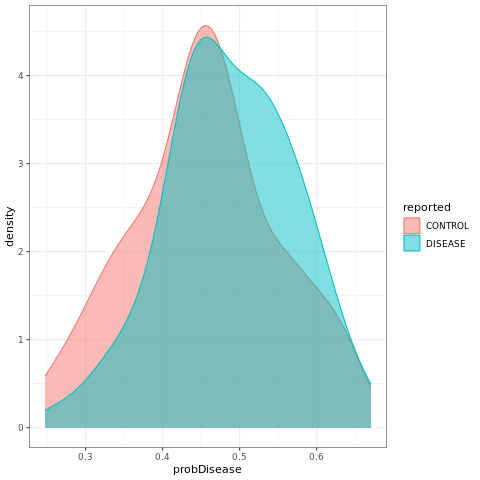

In [55]:
%%R
# Density plot
library("ggplot2")
pack <- "/home/jupyter/"
temp_data <- read.table("/home/jupyter/PRS_test/EAS/PRS_score_EAS_release.profile", header = T) 
temp_covs <- read.table("/home/jupyter/PRS_test/EAS/gp2_covs.csv", header = T, sep=",")
data <- merge(temp_data, temp_covs, by = "IID")
data$CASE <- data$PHENO - 1
meanControls <- mean(data$SCORE[data$CASE == 0])
sdControls <- sd(data$SCORE[data$CASE == 0])
head(data)
data$zSCORE <- (data$SCORE - meanControls)/sdControls

## Probability of disease calculation
Model <- glm(CASE ~ SCORE, data = data, family = 'binomial')
data$probDisease <- predict(Model, data, type = c("response"))
data$predicted <- ifelse(data$probDisease > 0.5, "DISEASE", "CONTROL")
data$reported <- ifelse(data$CASE == 1, "DISEASE","CONTROL")

# Density plot
densPlot <- ggplot(data, aes(probDisease, fill = reported, color = reported)) + geom_density(alpha = 0.5) + theme_bw()
ggsave(plot = densPlot, filename = "/home/jupyter/PRS_test/EAS/plotDensity_EAS.png", width = 8, height = 5, units = "in", dpi = 300)
densPlot

# Save out results

In [56]:
%%bash

WORK_DIR=/home/jupyter/PRS_test/EAS/
cd $WORK_DIR

gsutil cp PRS_score_EAS_release.profile gs://fc-c04486b2-8d7e-4359-a607-63643e9a7914
gsutil cp gp2_covs.csv gs://fc-c04486b2-8d7e-4359-a607-63643e9a7914
gsutil cp *.png gs://fc-c04486b2-8d7e-4359-a607-63643e9a7914


Copying file://PRS_score_EAS_release.profile [Content-Type=application/octet-stream]...
/ [1 files][  8.9 KiB/  8.9 KiB]                                                
Operation completed over 1 objects/8.9 KiB.                                      
Copying file://gp2_covs.csv [Content-Type=text/csv]...
/ [1 files][  8.2 MiB/  8.2 MiB]                                                
Operation completed over 1 objects/8.2 MiB.                                      
Copying file://plotDensity_EAS.png [Content-Type=image/png]...
Copying file://plotQuantile_EAS.png [Content-Type=image/png]...
/ [2 files][141.6 KiB/141.6 KiB]                                                
Operation completed over 2 objects/141.6 KiB.                                    
